In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:
car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


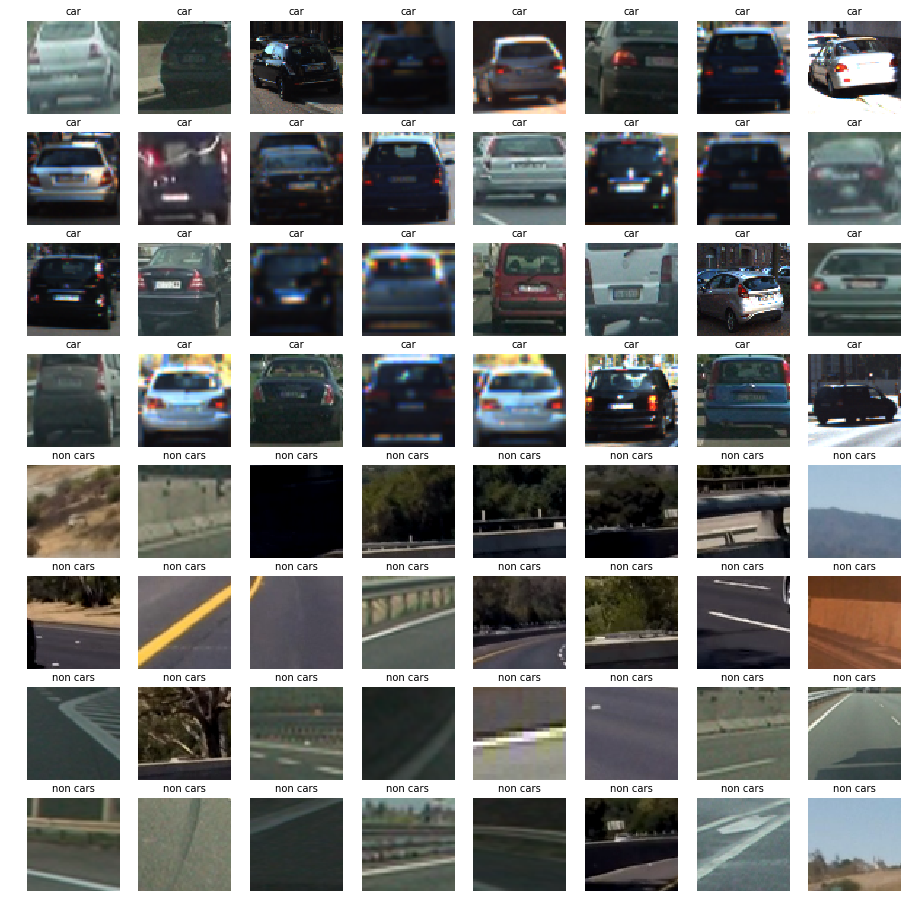

In [3]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# print some random cars and non-cars
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non cars', fontsize=10)
    axs[i].imshow(img)

In [4]:
# Note: This method is directly course

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print("Get hot features function defined")

Get hot features function defined


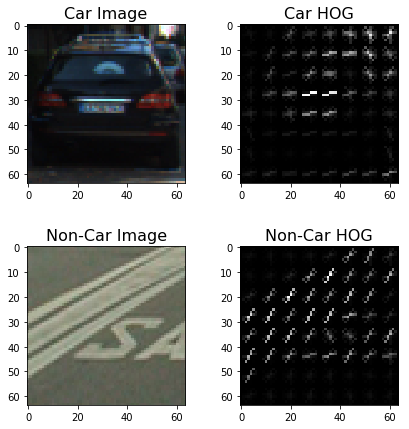

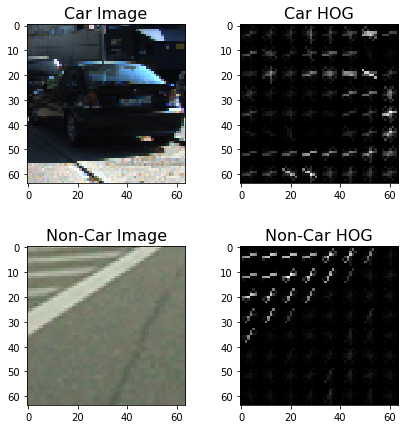

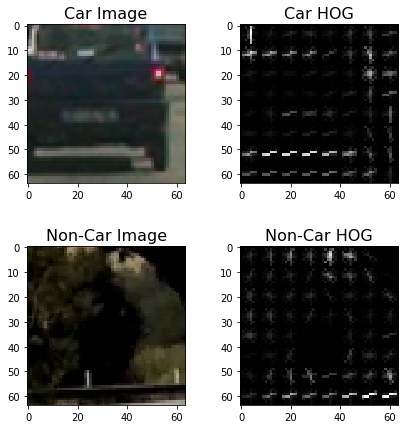

In [5]:
for i in range(1,4):
    
    index = np.random.randint(0,len(car_images))
    car_img = mpimg.imread(car_images[index])
    _, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    noncar_img = mpimg.imread(noncar_images[index])
    _, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

    # Plot the result
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
    f.subplots_adjust(hspace = .4, wspace=.2)
    ax1.imshow(car_img)
    ax1.set_title('Car Image', fontsize=16)
    ax2.imshow(car_dst, cmap='gray')
    ax2.set_title('Car HOG', fontsize=16)
    ax3.imshow(noncar_img)
    ax3.set_title('Non-Car Image', fontsize=16)
    ax4.imshow(noncar_dst, cmap='gray')
    ax4.set_title('Non-Car HOG', fontsize=16)

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Define a function to extract features(HOG, bin_spatial(), color_hist) features and visualization
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

print("feature extraction method defined")


feature extraction method defined


In [8]:
# Feature extraction parameters. This will be used across all methods
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb. YUV and YCrCb show good results
orient = 11 # Recommended between 6-12
pix_per_cell = 16 #will be multiples of 8
cell_per_block = 2 # Tried with both 1 and 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

In [9]:
t = time.time()
car_features = extract_features(car_images, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract ALL features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

64.05 Seconds to extract ALL features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [10]:
# Using a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

# Use classifier to predict data from sample test set.
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9806
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
0.00288 Seconds to predict 10 labels with SVC


In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: 
        ctrans_tosearch = np.copy(img_tosearch)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)

            #TODO: Skipping BIN_SPATIAL AND COLOR_HIST

            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

print("Find car method implemented")

Find car method implemented


In [12]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print("draw boxed method implemented")

draw boxed method implemented


4 rectangles found in image
0 rectangles found in image
1 rectangles found in image
6 rectangles found in image
3 rectangles found in image
6 rectangles found in image


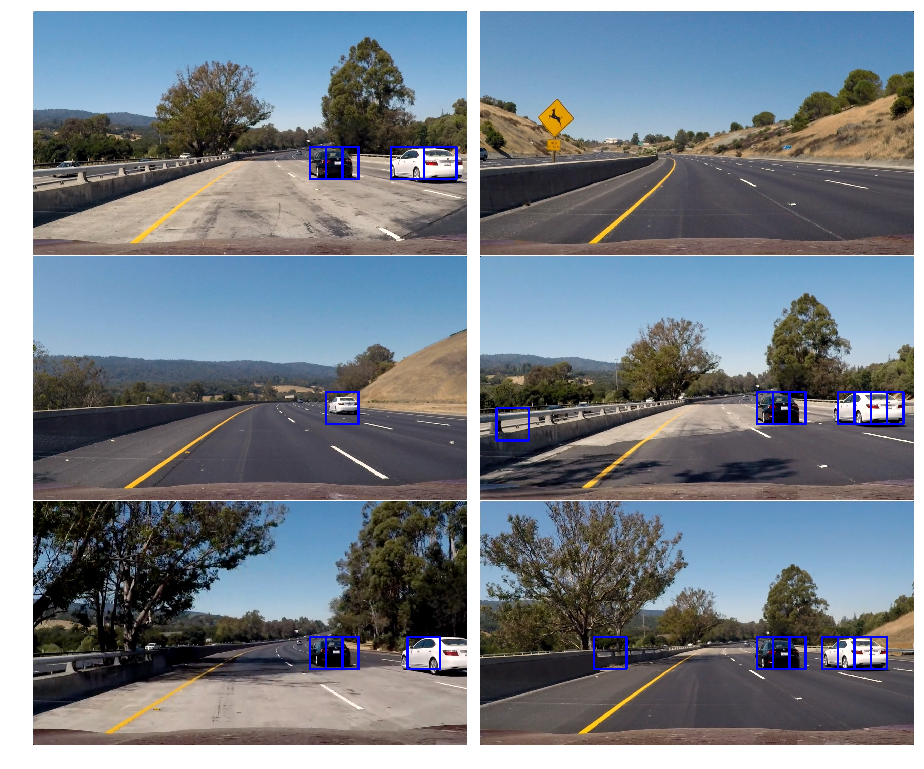

In [13]:
ystart = 400
ystop = 656
scale = 1.5

images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,13.5))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for index,fname in enumerate(images):
    img = mpimg.imread(fname)
    #fetch rectangles in image
    rectangles = rectangles = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, None, orient, 
                                        pix_per_cell, cell_per_block, None, None)
    print(len(rectangles), 'rectangles found in image')
    #display image with rectangles drawn 
    img_with_rects = draw_boxes(img, rectangles)
    
    axs[index].imshow(img_with_rects)
    axs[index].axis('off')

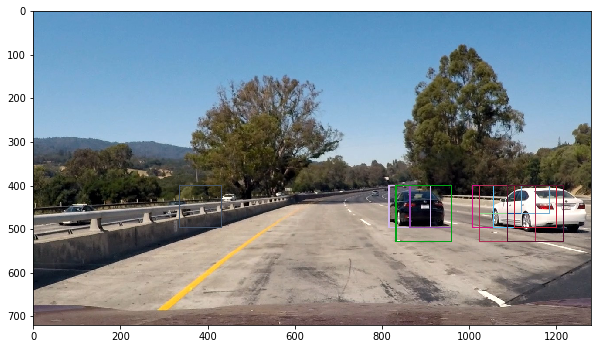

In [14]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []
params = [(400,480,1.0),(400,520,1.5),(400,560,2.0),(400,680,3.5)]

#Running find_cars method for different scale values to generate multiple-scaled search windows.
for ystart,ystop,scale in params:
    rectangles.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                                orient, pix_per_cell, cell_per_block, None, None))

# flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

In [15]:
# Detecting heat maps
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


#Applying thresold to remove false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

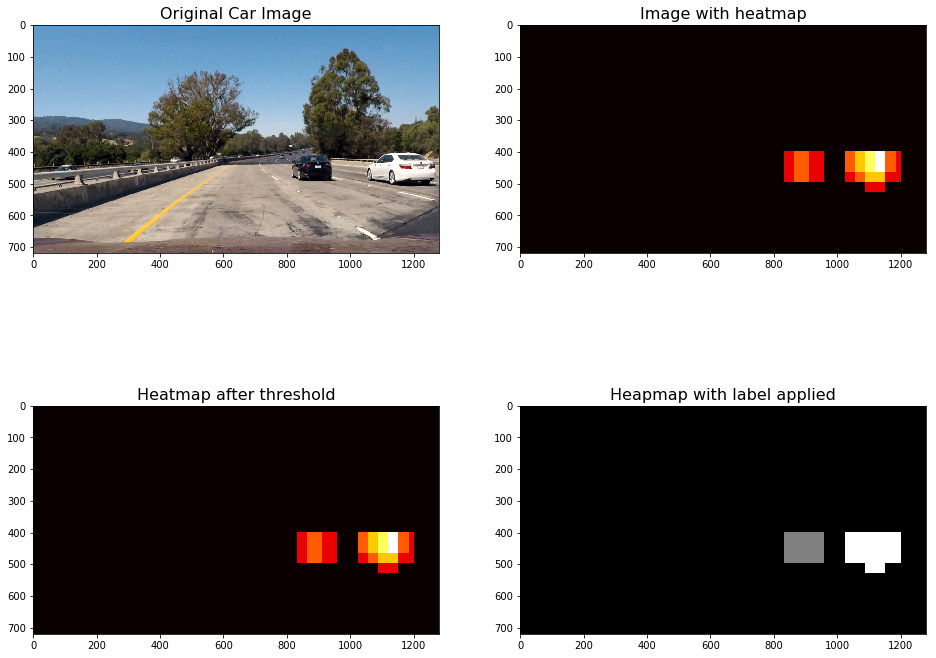

In [16]:
sample_img = mpimg.imread('./test_images/test1.jpg')
rectangles = []
params = [(400,480,1.0),(400,520,1.5),(400,560,2.0),(400,680,3.5)]

# Running find_cars method for different scale values to generate multiple-scaled search windows.
for ystart,ystop,scale in params:
    rectangles.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                                orient, pix_per_cell, cell_per_block, None, None))
# flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 

# Heatmap test
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)

# Heapmap thresold
heatmap_threshold_img = apply_threshold(heatmap_img, 1)

# Apply label to heatmap
heatmap_labels_img = label(heatmap_img)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(sample_img)
ax1.set_title('Original Car Image', fontsize=16)
ax2.imshow(heatmap_img, cmap='hot')
ax2.set_title('Image with heatmap', fontsize=16)
ax3.imshow(heatmap_threshold_img, cmap='hot')
ax3.set_title('Heatmap after threshold', fontsize=16)
ax4.imshow(heatmap_labels_img[0], cmap='gray')
ax4.set_title('Heapmap with label applied', fontsize=16)

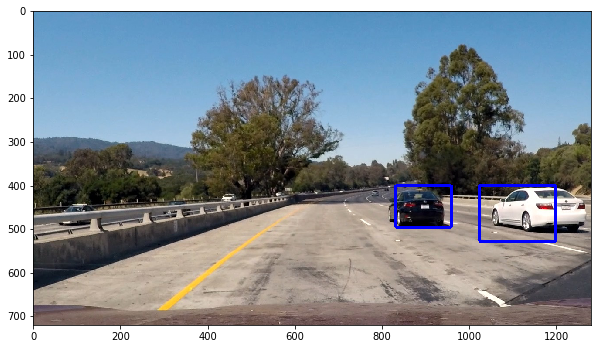

In [17]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(sample_img), heatmap_labels_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

process image method defined


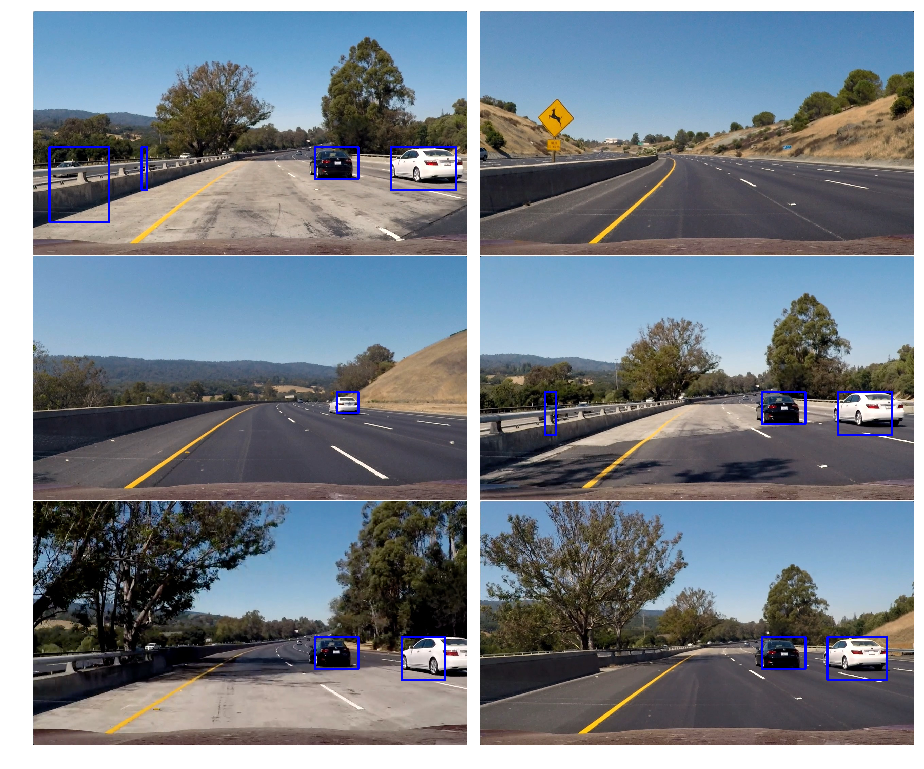

In [18]:
def pipeline(img):

    rectangles = []
    
    params = [(400,480,1.0),(400,520,1.5),(400,560,2.0),(400,680,3.5)]
    
    #Running find_cars method for different scale values to generate multiple-scaled search windows.
    for ystart,ystop,scale in params:
        rectangles.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('process image method defined')

images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,13.5))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for index,img in enumerate(images):
    axs[index].imshow(pipeline(mpimg.imread(img)))
    axs[index].axis('off')


In [19]:
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [20]:
def process_frame(img):

    rectangles = []
    
    params = [(400,480,1.0),(400,520,1.5),(400,560,2.0),(400,680,3.5)]
    
    # 1. Find cars and all rectangles
    for ystart,ystop,scale in params:
        rectangles.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    # 2. Draw heatmap with identified boxes
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    
    # 3. Remove false positives by applying thresolds.
    # I am using 1+len(det.prev_rects//2), half the number of rectangle contained in prev_rects. 
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    # 4. Label the heatmap image to identify number of cars in frame
    labels = label(heatmap_img)
    
    # 5. Draw identified cars areas on original image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # return final image
    return draw_img

print('process frame method defined')

process frame method defined


In [21]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('./project_video.mp4') 
clip_proj_out = clip_proj.fl_image(process_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)


[MoviePy] >>>> Building video P5.mp4
[MoviePy] Writing video P5.mp4


100%|█████████▉| 1260/1261 [04:48<00:00,  4.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5.mp4 

CPU times: user 4min 5s, sys: 42.5 s, total: 4min 48s
Wall time: 4min 49s


In [22]:
det = Vehicle_Detect()

proj_out_file = 'test_video_out.mp4'
clip_proj = VideoFileClip('test_video.mp4') 
clip_proj_out = clip_proj.fl_image(process_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  4.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 7.81 s, sys: 1.57 s, total: 9.38 s
Wall time: 11.2 s
